<a href="https://colab.research.google.com/github/SabinSapota/SabinSapota/blob/main/spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Spam detection**

In [ ]:
import wordcloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/spam/messages.csv'
df=pd.read_csv(path)
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [ ]:
#shape
df.shape

(2893, 3)

In [ ]:
# 62 missing value meaning that 62 emails were send without heading
df.isna().sum()

subject    62
message     0
label       0
dtype: int64

In [ ]:
#label count
# here 1 stands for spam and 0 stands for ham
df['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

In [ ]:
import plotly.express as px
fig=px.pie(names=df['label'].value_counts().index,values=df['label'].value_counts(),hole=0.5,
           title='Spam(1) vrs ham(0)  % in data set')

fig.show()

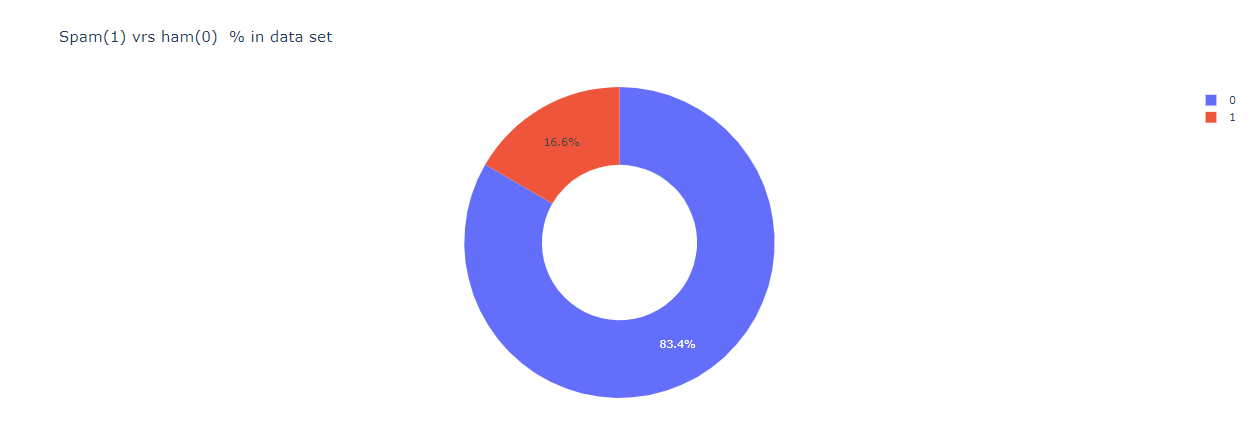

In [ ]:
# new columns is created which count the length of the message
df['msz_length']=df['message'].apply(lambda x:len(x))

In [ ]:
df.head(2)

,subject,message,label,msz_length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800


In [ ]:
#removing stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','iss','a'])

In [ ]:
#lets see  the preview of the first message
df.message[0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

In [ ]:
def clean_text(text):
  text=re.sub(r'£|\s$',' ',text)
 
  # removing any digit
  text=re.sub(r'\d+','',text)
  # removing any not word character
  
  text=re.sub(r'\W+',' ',text)
  text=re.sub(r'http',' ',text)
  text=re.sub(r'www',' ',text)
  text=re.sub(r'\s+',' ',text)
  
  return text
  
df.message=df.message.apply(clean_text)
df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))
df.message

0       content length apple research center us millio...
1       lang classification grimes joseph e barbara f ...
2       posting inquiry sergei atamas satamas umabnet ...
3       colleague researching differing degrees risk p...
4       earlier morning phone friend mine living south...
                              ...                        
2888    hello thanks stopping taken many new pics made...
2889    list owner kiddin invited join mailing list li...
2890    judging return post must sounded like kind sel...
2891    gotcha two separate fallacies argument n ary c...
2892    hello working thesis concerning attitudes towa...
Name: message, Length: 2893, dtype: object

In [ ]:
#nake new column
df['cleaned_length']=df.message.apply(lambda x:len(x))
df.head(2)

,subject,message,label,msz_length,cleaned_length
0,job posting - apple-iss research center,content length apple research center us millio...,0,2856,2081
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1304


In [ ]:
#Total length removal statistics
print("Original Length:",df.msz_length.sum())
print("Cleaned Length:",df.cleaned_length.sum())
print("Total Words Removed:",(df.msz_length.sum()) - (df.cleaned_length.sum()))

Original Length: 9344743
Cleaned Length: 6225881
Total Words Removed: 3118862


We observed that almost one-third amount of unwanted data is either cleaned or processed after length removal.

In [ ]:
#lets make a filter on spam
mask=(df.label==1)

In [ ]:
#data frame with spam message
df_spam=df.loc[mask,:]
df_spam.shape

(481, 3)

In [ ]:
#similarly we make another data set for ham message
#negate the above filter we get data frame for ham message
df_ham=df.loc[~mask,:]
df_ham.shape

(2412, 3)

**Exploratory Data Analysis:**

In [ ]:
df1=df.label.value_counts().reset_index()
df1.columns=['label','total_count']
df1

,label,total_count
0,0,2412
1,1,481


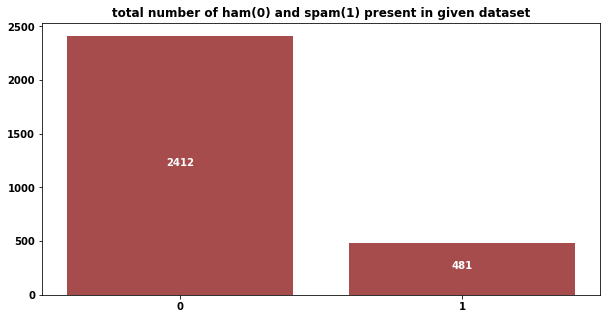

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
x=df1.label
y=df1.total_count
for i in range(len(x)):
        plt.text(i, y[i]//2,y[i], ha = 'center',fontweight='bold',color='white')
    
    # making the bar chart on the data with color red
plt.bar(x, y, color = 'maroon',alpha=0.7)
plt.yticks(fontweight='bold')
plt.title('total number of ham(0) and spam(1) present in given dataset',fontweight='bold')
plt.xticks(fontweight='bold',ticks=[0,1]);


In [ ]:
df_ham.columns

Index(['subject', 'message', 'label', 'msz_length', 'cleaned_length'], dtype='object')

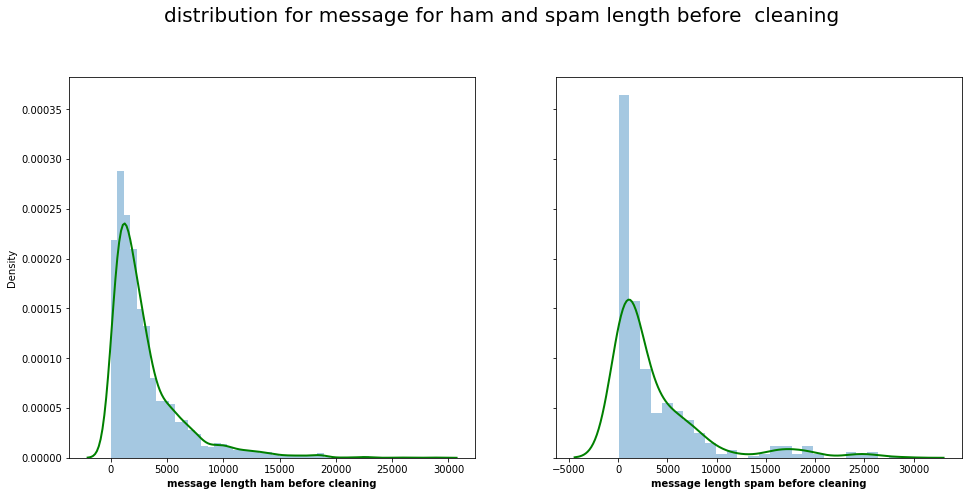

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7),sharey=True)
fig.suptitle('distribution for message for ham and spam length before  cleaning',size=20, y=1.02)
sns.distplot(ax=ax1,x=df_ham.msz_length,kde=True,kde_kws={'color':'green','lw':2})

sns.distplot(ax=ax2,x=df_spam.msz_length,kde=True,kde_kws={'color':'green','lw':2})
ax1.set_xlabel("message length ham before cleaning",fontweight='bold')
ax2.set_xlabel("message length spam before cleaning",fontweight='bold');
    
   

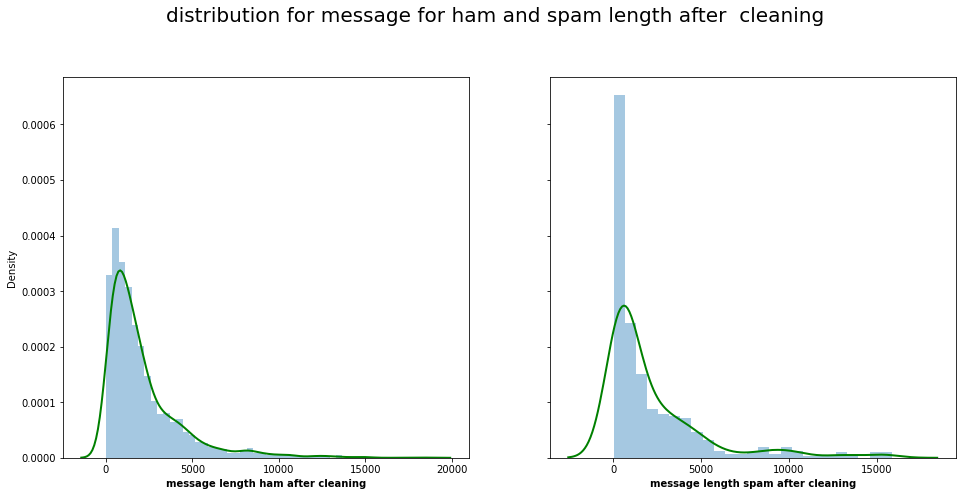

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7),sharey=True)
fig.suptitle('distribution for message for ham and spam length after  cleaning',size=20, y=1.02)
sns.distplot(ax=ax1,x=df_ham.cleaned_length,kde=True,kde_kws={'color':'green','lw':2})

sns.distplot(ax=ax2,x=df_spam.cleaned_length,kde=True,kde_kws={'color':'green','lw':2})
ax1.set_xlabel("message length ham after cleaning",fontweight='bold')
ax2.set_xlabel("message length spam after cleaning",fontweight='bold');
    

**Word Cloud**

In [ ]:
from wordcloud import WordCloud,STOPWORDS

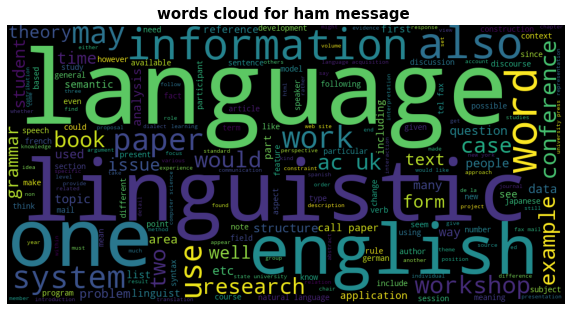

In [ ]:
text=' '.join(df_ham.message)
x=WordCloud(width=1000,height=500,stopwords=stopwords1).generate(text)
plt.figure(figsize=(10,7))
plt.imshow(x)
plt.axis('off')
plt.title('words cloud for ham message ',fontsize=15,fontweight='bold');


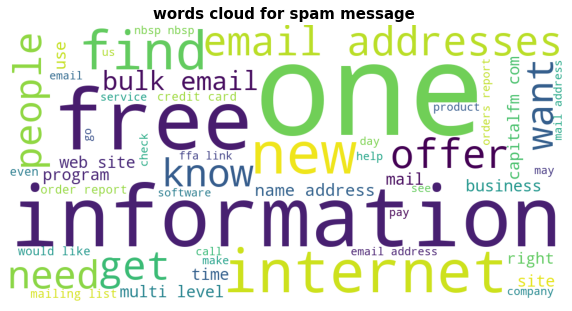

In [ ]:
text=' '.join(df_spam.message)
x=WordCloud(width=1000,height=500,stopwords=stopwords1,background_color='white',max_words=50).generate(text)
plt.figure(figsize=(10,7))
plt.imshow(x)
plt.axis('off')
plt.title('words cloud for spam message ',fontsize=15,fontweight='bold');

**Run and Evaluate selected models:**

In [ ]:
tf_vec = TfidfVectorizer()

SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')
features = tf_vec.fit_transform(df['message'])
X = features
y = df['label']

In [ ]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)         #test_size=0.20 random_state=42 test_size=0.15


#train the model by using SVM model
SVM.fit(X_train,Y_train)
#transfrom to test data
y_pred = SVM.predict(x_test)
#test score

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.988950276243094


In [ ]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [ ]:
# Checking Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       585
           1       1.00      0.94      0.97       139

    accuracy                           0.99       724
   macro avg       0.99      0.97      0.98       724
weighted avg       0.99      0.99      0.99       724



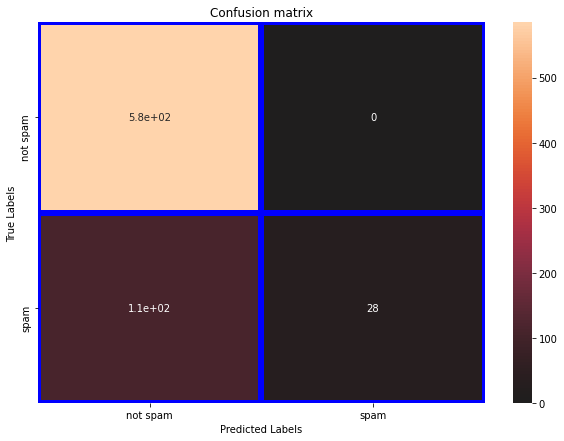

In [ ]:
#creating confusion matrix
conf_mat = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

In [ ]:
From above we can see,
True positve=580(correctly classified)
True negative=28(correctly classified)
False negative=110(incorrectly classified meaning  110 times model predicted spam message as not spam


From above we can see,


*   True positve=580(correctly classified)

*  True negative=28(correctly classified)


*   False negative=110(incorrectly classified meaning  110 times model predicted spam message as not spam






In [ ]:
# train the same data with naive base model
naive = MultinomialNB()
naive.fit(X_train,Y_train)
y_pred= naive.predict(x_test)
print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8466850828729282


In [ ]:
So, we can see clearly SVM  model gives more accuracy than compared to naive base approch